### We combine the `nsa_z001_002` and `nsa_z002_004` UDG sample. Then we select those biggest and brightest galaxies.

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress

import astropy.units as u
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

import pickle

In [31]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

In [36]:
udg_cat = Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

#### Only select bright ones, then rank by color

In [5]:
flag = ((udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0]) > 24.5) & (udg_cat['SB_eff_avg'][:, 0] < 25.5)
flag &= ((udg_cat['rhalf_spergel'] + udg_cat['rhalf_spergel_err']) > 3.)
flag &= (udg_cat['g-i'] < 0.6)

In [6]:
np.sum(flag)

20

In [7]:
cat = udg_cat[flag]

# Check repeatance
lsbg_coord = SkyCoord(cat['ra'], cat['dec'], unit='deg')

dist_mat = lsbg_coord[None, :].separation(lsbg_coord[:, None]).to(u.deg).value
np.fill_diagonal(dist_mat, 100)

if (dist_mat < (2 * u.arcsec).to(u.deg).value).sum() > 0:
    print('Have overlapping objects')
else:
    print('No overlapping objects')

No overlapping objects


In [8]:
# distance to host
lsbg_coord = SkyCoord(cat['ra'], cat['dec'], unit='deg')
host_coord = SkyCoord(cat['host_RA'], cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord).to(u.deg).value
dist_vir = dist / cat['host_r_vir_ang'].data

cat['dist_to_host_rvir'] = dist_vir
cat['SB_eff_avg_g'] = cat['SB_eff_avg'][:, 0]

cat.sort('g-i')

17H - 0H - 3H is observable

In [9]:
flag = ((cat['ra'] / 15 > 15) | (cat['ra'] / 15 < 3)) & (cat['dec'] < 10)
cat = cat[flag]

In [10]:
len(cat)

8

In [83]:
cat[['viz-id', 'PA_sym', 'PA_cen', 'ra', 'dec']]

viz-id,PA_sym,PA_cen,ra,dec
,,,deg,deg
int64,float64,float64,float64,float64
40777,0.10695338383170087,0.10695329300669683,337.3076356,-1.2152801
82230,-1.2567000445590608,-1.2566999467724742,340.1742102,3.1779487
79982,-0.9136609354598703,-0.9136594740940595,346.2485375,1.8339379
21534,0.5897462107330557,0.5897461439239039,350.35837,0.4649426
75212,1.4645096729472207,1.464509728855412,32.2729832,-6.3073727
75570,-0.8955246063079663,-0.8955255765022915,32.7693748,-2.9838995
45406,-1.2876993671701833,-1.2876994719212769,35.3498461,-5.3589374
86749,1.5671325166086458,1.5671325155572802,35.4086987,-5.4419486


In [87]:
with open('./Model/nsa_z001_002/spergel/nsa-79982-trained-model-spergel.df', 'rb') as f:
    blend, info, mask = dill.load(f)
    f.close()

XXX lineno: 447, opcode: 158


SystemError: unknown opcode

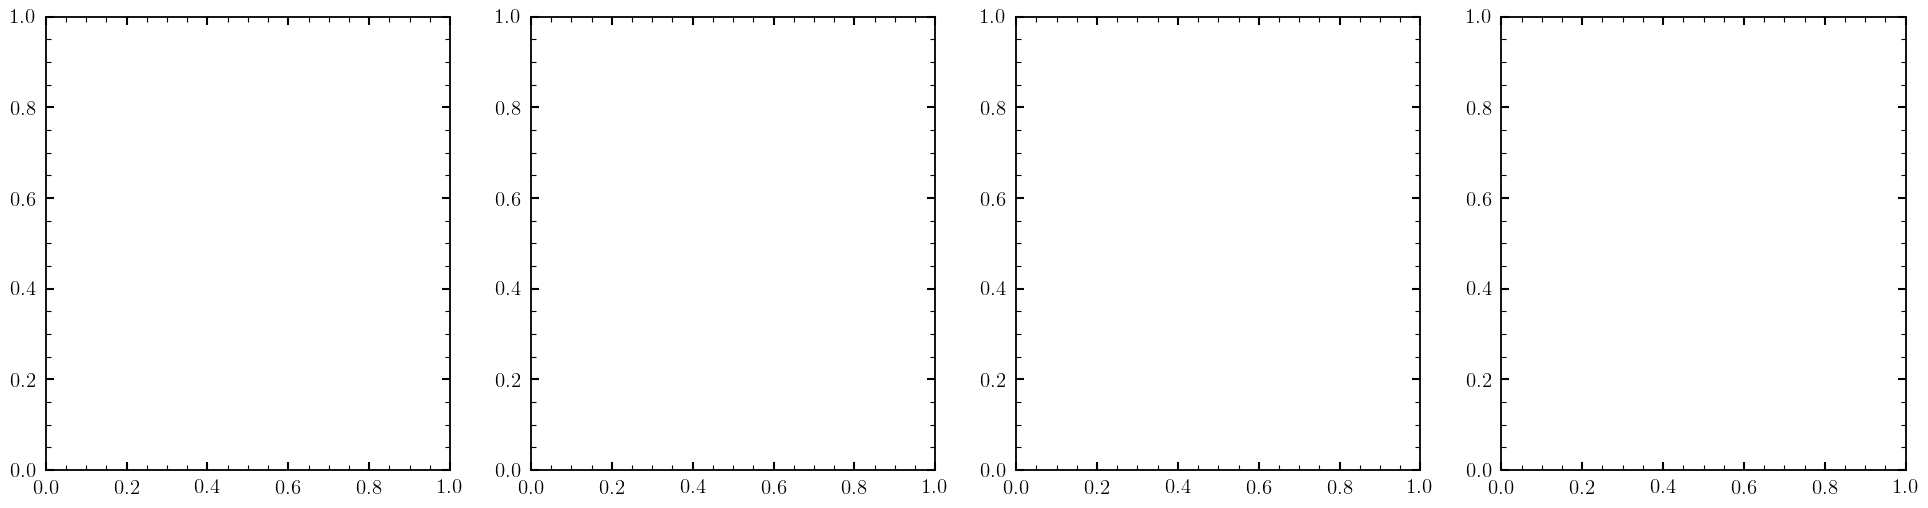

In [88]:
fig = kz.display.display_scarlet_results_tigress(
            blend,
            mask,
            zoomin_size=50,
            minimum=-0.3,
            stretch=1,
            Q=1,
            channels=blend.observations[0].channels,
            show_loss=True,
            show_mask=False,
            show_mark=False,
            scale_bar=True)

In [109]:
# Visual inspection for their hosts!!

# cat[['viz-id', 'host_RA', 'host_DEC']].write(
#     '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_hosts.txt', 
#     format='ascii')
# Then visual inspection
# host_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_hosts_spirals.txt', 
#                       format='ascii')
# cat['host_spiral'] = (host_cat['marked'] == 'true').astype(int)

In [11]:
cat['ra_abs'] = [ra - 360 if ra > 180 else ra for ra in cat['ra']]
cat.sort('ra_abs')
# sort by hour angle

In [12]:
elves_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/elves_objs.fits')

In [13]:
len(cat)

8

In [14]:
obscat = cat[['viz-id', 'ra', 'dec', 'rhalf_spergel', 'SB_eff_avg_g']]

In [15]:
dist = 10**((elves_cat['gmag'] - elves_cat['Mgmag'] - 25) / 5)
re_ang = 206265 * elves_cat['re'] / dist * 1e-6

elves_cat['rhalf_ang'] = re_ang

In [16]:
obscat['viz-id'] = obscat['viz-id'].astype(str)

In [17]:
elves_cat = hstack([elves_cat[['name', 'RA', 'Dec', 'rhalf_ang']], elves_cat['mu0V'] + 0.5])
elves_cat.rename_columns(elves_cat.colnames, obscat.colnames)

In [18]:
obscat = vstack([elves_cat, obscat])

In [19]:
obscat['exptime'] = 10**(0.4 * (obscat['SB_eff_avg_g'].data - 24.5)) * 0.5

In [85]:
0.7 * 60 / 15

2.8

In [84]:
obscat

viz-id,ra,dec,rhalf_spergel,SB_eff_avg_g,exptime
,deg,deg,arcsec,,
str21,float64,float64,float64,float64,float64
dw1912m6432,288.0953,-64.5419,5.874429843988169,24.84,0.6838644127979244
dw1859m6402,284.8605,-64.0396,6.57475402931067,25.17,0.9267658117074071
dw1903m6405,285.9146,-64.0985,5.531178845261018,25.79,1.640476465565594
40777,337.3076356,-1.2152801,2.976255456741576,25.09564252464412,0.8654201725628239
82230,340.1742102,3.1779487,2.845967979569235,25.434926596139878,1.1828798745432105
79982,346.2485375,1.8339379,7.175533465782251,25.011417066247954,0.8008235403739389
21534,350.35837,0.4649426,3.1386007559298728,25.0221527172495,0.8087812812830479
75212,32.2729832,-6.3073727,4.031836932045927,25.143687382016545,0.9045757837572622


40777-offset1 337.3067 -1.2109 g=19.98, r=18.39, z=16.30
40777-offset2 337.3480, -1.2038 g=15.96, r=15.24, z=14.95

82230-offset1 340.1666 3.1682 g=17.69, r=16.95, z=16.54
82230-offset2 340.2023, 3.1544 g=11.52, r=10.94, z=10.94

79982-offset1 346.2416 1.8224 g=18.60, r=17.79, z=17.39
79982-offset2 346.2231, 1.8689 g=13.94, r=13.64, z=13.77

21534-offset1 350.3705 0.4829 g=17.81, r=17.33, z=17.17
21534-offset2 350.3800, 0.4737 g=13.52, r=13.16, z=13.12

75212-offset1 32.2952, -6.2984 g=15.17, r=14.60, z=14.42
75212-offset2 32.2553, -6.3123 g=19.14, r=18.78, z=18.67

75570-offset1g 32.7960, -2.9715 g=17.48, r=16.48, z=15.79
75570-offset2 32.7933, -3.0199 g=13.24, r=13.63, z=13.05

45406-offset1 35.3536, -5.3667 g=17.59, r=16.21, z=15.26
45406-offset2 35.3224, -5.3563 g=15.41, r=15.08, z=15.01

86749-offset1 35.4551, -5.4455 g=14.42, r=13.86, z=13.73
86749-offset2 35.3758, -5.4727 g=16.63, r=15.27, z=14.40

In [41]:
offsets = Table.read(
    '/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/magellan_proposal/offset_stars.txt', 
    format='ascii')

In [42]:
offsets

viz-id,ra,dec,g,r,z
str14,float64,float64,float64,float64,float64
40777-offset1,337.3067,-1.2109,19.98,18.39,16.3
40777-offset2,337.348,-1.2038,15.96,15.24,14.95
82230-offset1,340.1666,3.1682,17.69,16.95,16.54
82230-offset2,340.2023,3.1544,11.52,10.94,10.94
79982-offset1,346.2416,1.8224,18.6,17.79,17.39
79982-offset2,346.2231,1.8689,13.94,13.64,13.77
21534-offset1,350.3705,0.4829,17.81,17.33,17.17
21534-offset2,350.38,0.4737,13.52,13.16,13.12
75212-offset1,32.2952,-6.2984,15.17,14.6,14.42


In [58]:
obscat_w_stars = vstack([obscat, offsets], join_type='outer')

In [59]:
_ra = obscat_w_stars['ra'].data.copy()
_ra[_ra > 180] -= 360

In [60]:
obscat_w_stars = obscat_w_stars[np.argsort(_ra)]

In [61]:
hstack([obscat_w_stars[['viz-id', 'ra', 'dec']], 
       ],
      ).write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_w_offsets.txt', 
    format='ascii', overwrite=True)

In [21]:
hstack([obscat[['viz-id', 'ra', 'dec', 'rhalf_spergel', 'SB_eff_avg_g']], 
       ],
      ).write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_July22_bright_large.txt', 
    format='ascii', overwrite=True)

Field#1: reference number (can use alphanumeric characters or a decimal number)

Field#2: object name (can use alphanumeric characters, plus, minus, period, and underscore, but no whitespace)

Field#3: RA given in hh:mm:ss.s or in decimal hours

Field#4: Dec given in ±dd:mm:ss or in decimal degrees

Field#5: equinox given in yyyy.y

Field#6: proper motion in RA given in seconds of time per year (s.ss)

Field#7: proper motion in Dec given in arcseconds per year (s.ss).

The next two fields are instrument dependent and need to be specified correctly. This is the responsibility of the observer, not the Telescope Operator. Please read below for details of the various rotator modes available with the various instruments.

Field#8: instrument rotator offset angle given in degrees (dd.d)

Field#9: instrument rotator offset mode

The next 6 required fields (10-15) specify positions of the guide probes. If you dont need to preselect guide stars, please use zero values for these fields.

Field#10: RA of guide probe#1 given in hh:mm:ss.s or decimal hours

Field#11: Dec of guide probe#1 given in ±dd:mm:ss or decimal degrees

Field#12: equinox of guide probe#1 positions given in yyyy.y

Field#13: RA of guide probe#2 given in hh:mm:ss.s or decimal hours

Field#14: Dec of guide probe#2 given in ±dd:mm:ss or decimal degrees

Field#15: equinox of guide probe#2 positions given in yyyy.y

Field#16: observation epoch of the given coords as in yyyy.y , for example 2015.5 for most of GAIA published observations. This field is relevant if the proper motion (PM) is not zero, as the current position (Pnow) of such object will be calculated as:

### write to catalog

In [62]:
length = len(obscat_w_stars)

obs_cat = Table(
    [Column(name='refnum', length=length, dtype=int), 
    Column(name='objname', length=length), 
    Column(name='RA', length=length), 
    Column(name='Dec', length=length), 
    Column(name='Equinox', length=length), 
    Column(name='pmRA', length=length), 
    Column(name='pmDec', length=length), 
    Column(name='offset', length=length), 
    Column(name='rot', length=length), 
    Column(name='RA_probe1', length=length), 
    Column(name='Dec_probe1', length=length), 
    Column(name='Equinox_probe1', length=length), 
    Column(name='RA_probe2', length=length), 
    Column(name='Dec_probe2', length=length), 
    Column(name='Equinox_probe2', length=length), 
    Column(name='pm_epoch', length=length),]
               )

In [63]:
obs_cat['refnum'] = np.arange(0, length)
obs_cat['objname'] = [f'UDG{num}' for num in obscat_w_stars['viz-id']]

coords = SkyCoord(ra=obscat_w_stars['ra'], dec=obscat_w_stars['dec'], unit='deg')
obs_cat['RA'] = [coo.ra.to_string(u.hour, sep=':', precision=2) for coo in coords]
obs_cat['Dec'] = [coo.dec.to_string(u.deg, sep=':', precision=2) for coo in coords]
obs_cat['Equinox'] = np.ones(length) * 2000.0
obs_cat['pmRA'] = np.ones(length) * 0.0
obs_cat['pmDec'] = np.ones(length) * 0.0

obs_cat['offset'] = np.ones(length) * -62.5
obs_cat['rot'] = ['HRZ'] * length

In [86]:
obs_cat

refnum,objname,RA,Dec,Equinox,pmRA,pmDec,offset,rot,RA_probe1,Dec_probe1,Equinox_probe1,RA_probe2,Dec_probe2,Equinox_probe2,pm_epoch
int64,str17,str11,str12,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64
0,UDGdw1859m6402,18:59:26.52,-64:02:22.56,2000.0,0.0,0.0,-62.5,HRZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,UDGdw1903m6405,19:03:39.50,-64:05:54.60,2000.0,0.0,0.0,-62.5,HRZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,UDGdw1912m6432,19:12:22.87,-64:32:30.84,2000.0,0.0,0.0,-62.5,HRZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,UDG40777-offset1,22:29:13.61,-1:12:39.24,2000.0,0.0,0.0,-62.5,HRZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,UDG40777,22:29:13.83,-1:12:55.01,2000.0,0.0,0.0,-62.5,HRZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,UDG40777-offset2,22:29:23.52,-1:12:13.68,2000.0,0.0,0.0,-62.5,HRZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,UDG82230-offset1,22:40:39.98,3:10:05.52,2000.0,0.0,0.0,-62.5,HRZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,UDG82230,22:40:41.81,3:10:40.62,2000.0,0.0,0.0,-62.5,HRZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,UDG82230-offset2,22:40:48.55,3:09:15.84,2000.0,0.0,0.0,-62.5,HRZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
obs_cat.write('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/obs_cat.txt', 
              format='ascii.commented_header', overwrite=True)

In [26]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

from astropy.coordinates import SkyCoord
from astroplan import FixedTarget
from astroplan import Observer
from astroplan.plots import plot_airmass 
observer = Observer.at_site('Las Campanas Observatory', timezone="US/Eastern")

In [27]:
objs = []
for i in range(len(obscat)):
    coord = SkyCoord(obscat['ra'][i], obscat['dec'][i], unit='deg')
#     obj = FixedTarget(name=str(cat['viz-id'][i]), coord=coord)
    obj = FixedTarget(name=None, coord=coord)
    objs.append(obj)

In [28]:
colors = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b',
          '#ffffbf','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2',] * 2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'UDG observation')

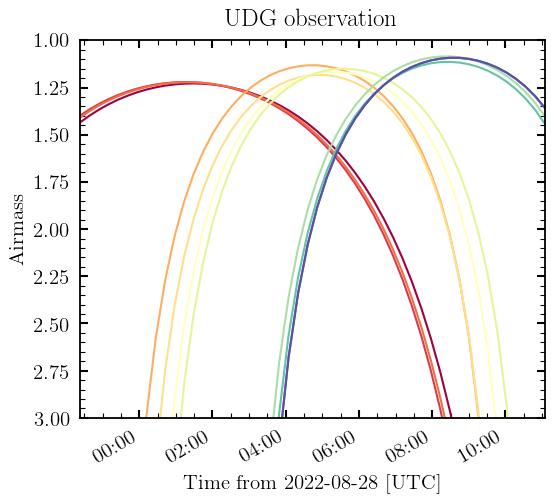

In [32]:
time = Time('2022-08-29 02:00')
sunset_time = observer.sun_set_time(time, which='nearest')
sunrise_time = observer.sun_rise_time(time, which='nearest')

observe_time = sunset_time + np.linspace(0, (sunrise_time - sunset_time).to(u.hour).value, 50) * u.hour

for i in range(len(obscat)):
    plot_airmass(objs[i], observer, observe_time, style_kwargs={'color': colors[i]}, use_local_tz=True)
# plot_airmass(objs[1], observer, observe_time)
# plot_airmass(objs[2], observer, observe_time)

plt.axvline(23)
plt.legend(shadow=True, loc=2)
plt.title('UDG observation')

In [33]:
obscat

viz-id,ra,dec,rhalf_spergel,SB_eff_avg_g,exptime
,deg,deg,arcsec,,
str21,float64,float64,float64,float64,float64
dw1912m6432,288.0953,-64.5419,5.874429843988169,24.84,0.6838644127979244
dw1859m6402,284.8605,-64.0396,6.57475402931067,25.17,0.9267658117074071
dw1903m6405,285.9146,-64.0985,5.531178845261018,25.79,1.640476465565594
40777,337.3076356,-1.2152801,2.976255456741576,25.09564252464412,0.8654201725628239
82230,340.1742102,3.1779487,2.845967979569235,25.434926596139878,1.1828798745432105
79982,346.2485375,1.8339379,7.175533465782251,25.011417066247954,0.8008235403739389
21534,350.35837,0.4649426,3.1386007559298728,25.0221527172495,0.8087812812830479
75212,32.2729832,-6.3073727,4.031836932045927,25.143687382016545,0.9045757837572622


In [283]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

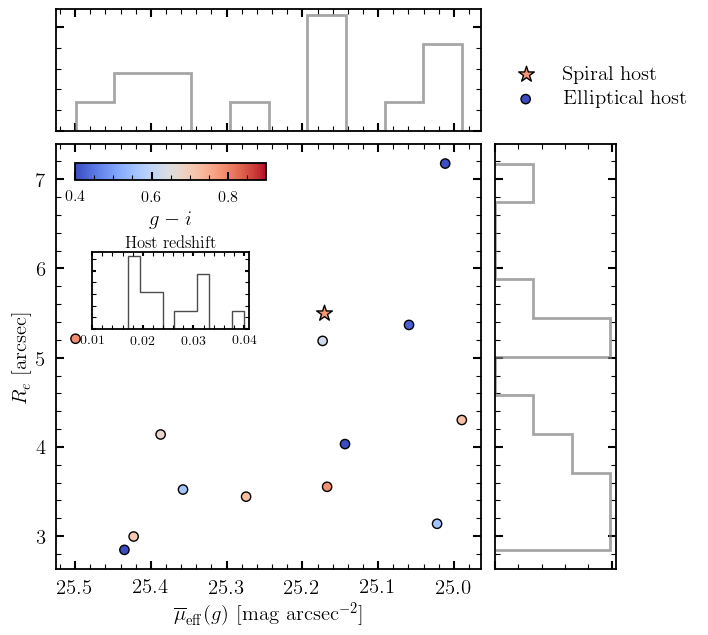

In [284]:
# start with a square Figure
fig = plt.figure(figsize=(7, 7))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.set_yticklabels([])
# ax_histx.set_xticklabels([])
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.set_xticklabels([])

flag = (cat['host_spiral'] == 1)
sct = ax.scatter(
    cat['SB_eff_avg_g'][flag],
    cat['rhalf_spergel'][flag],
    c=(cat['mag'][:, 0] - cat['mag'][:, 2])[flag],
    vmin=0.4, vmax=0.9,
    cmap='coolwarm',
    marker='*',
    edgecolor='k',
    s=140,
    alpha=1,
    label='Spiral host'
    )

sct = ax.scatter(
    cat['SB_eff_avg_g'][~flag],
    cat['rhalf_spergel'][~flag],
    c=(cat['mag'][:, 0] - cat['mag'][:, 2])[~flag],
    vmin=0.4, vmax=0.9,
    cmap='coolwarm',
    edgecolor='k',
    s=45,
    alpha=1,
    label='Elliptical host'
    )

ax.legend(loc='upper right', bbox_to_anchor=(1.55, 1.25))

cax = inset_axes(ax, width="45%", height="4%", 
                 loc='upper left', bbox_to_anchor=(0.02, -0.02, 1, 1),
                 bbox_transform=ax.transAxes) 
plt.colorbar(sct, cax=cax, label='$g-i$',
             orientation='horizontal')
cax.tick_params(labelsize=11.5)

# ax.set_xlim(29, 24)
# ax.set_ylim(1.6, 14)
ax.invert_xaxis()
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$R_e\ [\rm arcsec]$')

ax_histx.hist(cat['SB_eff_avg_g'], lw=2,
              histtype='step', density=True, color='gray', 
              alpha=0.7, label='$g-i > 0.7$')
ax_histy.hist(cat['rhalf_spergel'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='gray', alpha=0.7)
# ax_histy.set_xscale('log')

# show redshift
cax2 = inset_axes(ax, width='37%', height='18%', 
                  loc='upper left', 
                  bbox_to_anchor=(0.06, -0.23, 1, 1),
                  bbox_transform=ax.transAxes)
cax2.hist(cat['host_z'], histtype='step', density=True, color='k', alpha=0.7)
cax2.set_title('Host redshift', fontsize=12, pad=3)
cax2.set_yticklabels([])
cax2.set_xticks([0.01, 0.02, 0.03, 0.04])
cax2.tick_params(axis='both', which='both', length=3, labelsize=10, pad=4)

# plt.savefig('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/sample_summary.png')

##### Write to Tex

In [99]:
tex_table = hstack([selected_cat[['viz-id', 'ra', 'dec']], 
        Column(data=selected_cat['rhalf_spergel'] * 0.168, name=r'$R_e$'),
        Column(data=selected_cat['SB_eff_avg'][:, 0], name=r'$\overline{\mu}_e(g)$'), 
        Column(data=selected_cat['mag'][:, 0], name=r'$g$'),
        Column(data=selected_cat['mag'][:, 0] - selected_cat['mag'][:, 2], name=r'$g-i$'),
        Column(data=selected_cat['host_z'], name=r'$z_{\mathrm{host}}$'),
        Column(data=selected_cat['dist_to_host_rvir'], name=r'$D_{\rm host}$'),
        Column(data=['S' if t == 1 else 'E' for t in selected_cat['host_spiral']], name='Host type')],
      )
tex_table.rename_column('viz-id', 'ID')
coords = SkyCoord(selected_cat['ra'], selected_cat['dec'], unit='deg')
tex_table['ra'] = (coords.ra / 15).to_string(sep=':', precision=0, fields=3)
tex_table['ra'] = ['0' + t if len(t) == 7 else t for t in tex_table['ra']]
tex_table['dec'] = np.array([f'+{t:.4f}' if t > 0 else f'{t:.4f}' for t in tex_table['dec']])
tex_table.rename_column('ra', 'R.A.')
tex_table.rename_column('dec', 'Dec.')

tex_table[r'$R_e$'] = [f'{t:.2f}' for t in tex_table[r'$R_e$']]
tex_table[r'$g$'] = [f'{t:.2f}' for t in tex_table[r'$g$']]
tex_table[r'$g-i$'] = [f'{t:.2f}' for t in tex_table[r'$g-i$']]
tex_table[r'$\overline{\mu}_e(g)$'] = [f'{t:.2f}' for t in tex_table[r'$\overline{\mu}_e(g)$']]
tex_table[r'$z_{\mathrm{host}}$'] = [f'{t:.4f}' for t in tex_table[r'$z_{\mathrm{host}}$']]
tex_table[r'$D_{\rm host}$'] = [f'{t:.2f}' for t in tex_table[r'$D_{\rm host}$']]

In [100]:
from astropy.io import ascii

In [101]:
selected_id

array([75619, 27795, 86113, 67181, 69381, 65780, 29808, 79982, 30269,
       14216, 81835, 21112, 85963, 73208, 75450])

In [102]:
ascii.write(tex_table, 
            Writer=ascii.Latex, 
               latexdict={'preamble': r'\begin{center}',
                       'tablefoot': r'\end{center}',
                       'tabletype': 'table*',
                          'units': {r'$R_e$': '(arcsec)', 
                                    r'$\overline{\mu_e}(g)$': r'(mag arcsec$^{-2}$)',
                                    r'$g$': '(mag)',
                                    r'$g-i$': '(mag)',
                                    r'$D_{\rm host}$': "($R_{\mathrm{vir}}$)"}
                         })

\begin{table*}
\begin{center}
\begin{tabular}{cccccccccc}
ID & R.A. & Dec. & $R_e$ & $\overline{\mu}_e(g)$ & $g$ & $g-i$ & $z_{\mathrm{host}}$ & $D_{\rm host}$ & Host type \\
 &  &  & (arcsec) &  & (mag) & (mag) &  & ($R_{\mathrm{vir}}$) &  \\
75619 & 01:07:24 & -0.6802 & 4.56 & 24.57 & 19.27 & 0.83 & 0.0177 & 0.35 & E \\
27795 & 22:56:25 & -1.2076 & 13.07 & 24.58 & 17.00 & 0.53 & 0.0103 & 0.87 & S \\
86113 & 23:30:43 & +0.2328 & 6.17 & 24.65 & 18.70 & 0.56 & 0.0172 & 0.50 & E \\
67181 & 23:21:26 & +1.8713 & 9.87 & 24.71 & 17.75 & 0.71 & 0.0296 & 0.87 & E \\
69381 & 01:56:29 & -4.5307 & 4.72 & 25.05 & 19.68 & 0.87 & 0.0177 & 0.20 & S \\
65780 & 02:23:01 & -1.8268 & 4.50 & 25.09 & 19.83 & 0.77 & 0.0194 & 0.52 & S \\
29808 & 01:07:27 & -0.6829 & 8.17 & 25.10 & 18.54 & 0.93 & 0.0177 & 0.39 & E \\
79982 & 23:05:00 & +1.8339 & 6.96 & 25.12 & 18.92 & 0.48 & 0.0171 & 0.86 & E \\
30269 & 01:03:30 & -0.6638 & 5.20 & 25.17 & 19.59 & 0.93 & 0.0179 & 0.85 & E \\
14216 & 01:55:50 & -2.5690 & 5.04 &

In [103]:
gal1 = selected_cat[selected_cat['viz-id'] == 75619]

In [104]:
gal2 = selected_cat[selected_cat['viz-id'] == 29808]

In [105]:
gal1_coord = SkyCoord(gal1['ra'], gal1['dec'], unit='deg')
gal2_coord = SkyCoord(gal2['ra'], gal2['dec'], unit='deg')

In [106]:
gal1_coord.separation(gal2_coord)

<Angle [0.01149488] deg>

In [ ]:
41.4

In [110]:
gal1['host_ang_diam_dist'].data * 41.4 / 206265 * 1000

array([15.38789361])

In [114]:
(13*u.hourangle + 2 * u.arcmin + 16 * u.arcsec).to(u.hourangle).to(u.deg)

<Quantity 195.03777778 deg>

In [116]:
(13 + 2 / 60 + 16 / 3600) * 15

195.56666666666666

In [115]:
(28 * u.deg + 57 * u.arcmin + 17 * u.arcsec).to(u.deg)

<Quantity 28.95472222 deg>

##### Exp time

In [122]:
def calc_exp(SB):
    return 10**(0.4 * (SB - 24.5)) * (10 / 6.5)**2 * (0.3/0.2) * 20 * u.min

$$t_{LDSS3} / t_{LRIS} = (D_{m} / D_{k})^{-2} \cdot (\epsilon_{m} / \epsilon_{k})^{-1} \cdot 10^{0.4 (\mu - 24.5)}$$

$$t_{LDSS3} / t_{LRIS} = (6.5 / 10)^{-2} \cdot (0.1 / 0.3)^{-1} \cdot 10^{0.4 (\mu - 24.5)}$$

In [123]:
calc_exp(24.5).to(u.hour)

<Quantity 1.18343195 h>

In [151]:
calc_exp(25.5).to(u.hour)

<Quantity 2.97264666 h>

In [158]:
(selected_cat['g-i'] < 0.75).sum()

5

In [153]:
exptime = calc_exp(selected_cat['SB_eff_avg_g']).to(u.hour)
exptime[selected_cat['g-i'] < 0.75] = 0.5 * u.hour

In [154]:
exptime

<Quantity [1.25678179, 0.5       , 0.5       , 0.5       , 1.96054604,
           2.04492744, 2.05142035, 0.5       , 2.18646428, 0.5       ,
           2.31985537, 2.50269111, 2.69731946, 2.71176347, 2.79421843] h>

In [155]:
exptime.sum()

<Quantity 25.02598773 h>

In [149]:
np.array([3968, 3933]) * (1 + 0.04)

array([4126.72, 4090.32])

In [150]:
10800 / 3600

3.0

In [125]:
300000 / 450

666.6666666666666

In [128]:
1 / 509 * 300000 / 2.355

250.27217098594718

In [129]:
1900 / 5

380.0

In [135]:
R = 4100 * 0.75 / 5
300000 / R / 2.355

207.13582932007665

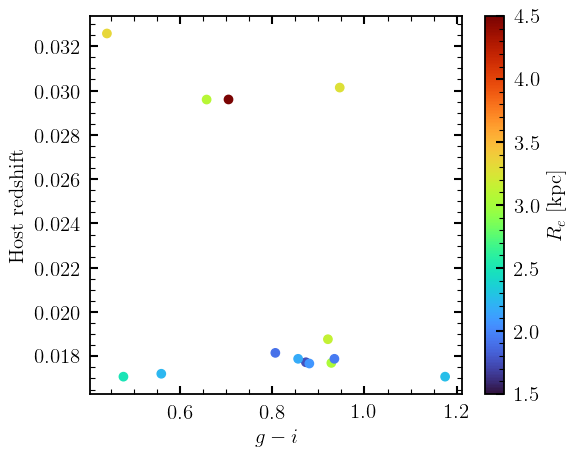

In [273]:
plt.scatter(cat['mag'][:, 0] - cat['mag'][:, 2], 
            cat['host_z'], 
            c=cat['rhalf_circularized_phys'], vmin=1.5, vmax=4.5)
plt.xlabel('$g-i$')
plt.ylabel('Host redshift')
plt.colorbar(label='$R_e$ [kpc]')

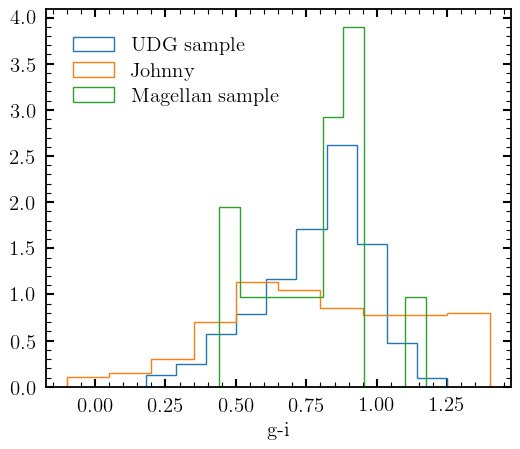

In [274]:
johnny = Table.read('./Catalog/Greco_S18A_lsbg.fits')
plt.hist(udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2], histtype='step', density=True, label='UDG sample')
plt.hist(johnny['g-i'], histtype='step', density=True, label='Johnny')
plt.hist(cat['mag'][:, 0] - cat['mag'][:, 2], density=True, histtype='step', label='Magellan sample')
plt.xlabel('g-i')
plt.legend(loc='upper left')

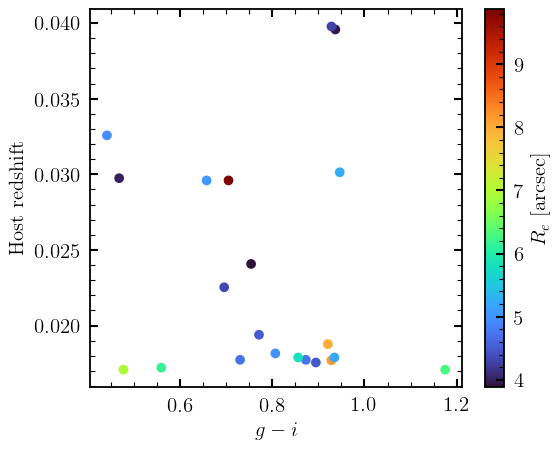

In [245]:
plt.scatter(cat['mag'][:, 0] - cat['mag'][:, 2], 
            cat['host_z'], 
            c=cat['rhalf_spergel'] * 0.168)
plt.xlabel('$g-i$')
plt.ylabel('Host redshift')
plt.colorbar(label='$R_e$ [arcsec]')

In [196]:
hstack([cat[['viz-id', 'ra', 'dec']], 
        Column(data=np.round(cat['rhalf_spergel'] * 0.168, 2), name='rhalf_'),
        Column(data=np.round(cat['SB_eff_avg'][:, 0], 2), name='SB_eff_avg_g'), 
        Column(data=np.round(cat['mag'][:, 0], 2), name='g_mag'),
        Column(data=np.round(cat['mag'][:, 0] - cat['mag'][:, 2], 2), name='g-i'),
       Column(data=np.round(cat['dist_to_host_rvir'], 2), name='dist2host_rvir')]
      ).write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_cat_latex.tex', 
    format='ascii.latex')

In [197]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [199]:
from astropy.coordinates import SkyCoord
from astroplan import FixedTarget
from astroplan import Observer
from astroplan.plots import plot_airmass 
observer = Observer.at_site('Las Campanas Observatory')

In [235]:
objs = []
for i in range(15):
    coord = SkyCoord(cat['ra'][i], cat['dec'][i], unit='deg')
#     obj = FixedTarget(name=str(cat['viz-id'][i]), coord=coord)
    obj = FixedTarget(name=None, coord=coord)
    objs.append(obj)

No handles with labels found to put in legend.


Text(0.5, 1.0, '2022-09-15 02:00:00.000')

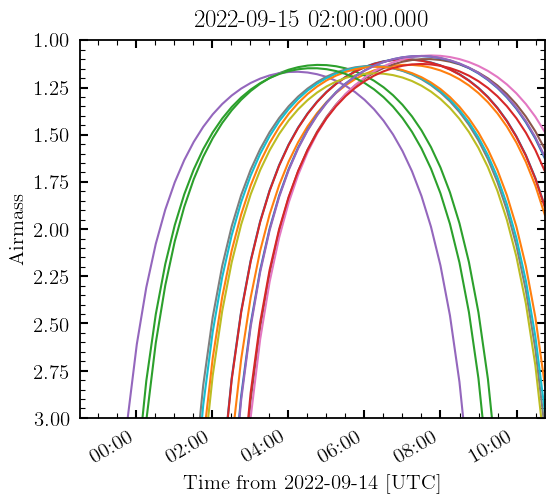

In [243]:
time = Time('2022-09-15 02:00')
sunset_time = observer.sun_set_time(time, which='nearest')
sunrise_time = observer.sun_rise_time(time, which='nearest')

observe_time = sunset_time + np.linspace(0, (sunrise_time - sunset_time).to(u.hour).value, 50) * u.hour

for i in range(15):
    plot_airmass(objs[i], observer, observe_time, )
# plot_airmass(objs[1], observer, observe_time)
# plot_airmass(objs[2], observer, observe_time)

plt.legend(shadow=True, loc=2)
plt.title(time)

No handles with labels found to put in legend.


Text(0.5, 1.0, '2022-11-15 02:00:00.000')

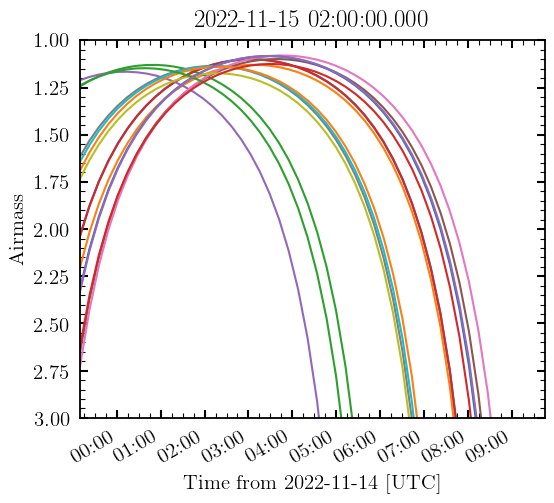

In [242]:
time = Time('2022-11-15 02:00')
sunset_time = observer.sun_set_time(time, which='nearest')
sunrise_time = observer.sun_rise_time(time, which='nearest')

observe_time = sunset_time + np.linspace(0, (sunrise_time - sunset_time).to(u.hour).value, 50) * u.hour

for i in range(15):
    plot_airmass(objs[i], observer, observe_time, )
# plot_airmass(objs[1], observer, observe_time)
# plot_airmass(objs[2], observer, observe_time)

plt.legend(shadow=True, loc=2)
plt.title(time)